## import and load

In [139]:
import json
import os
import numpy as np
import pandas as pd

In [140]:
def load_json(filepath, encoding='utf-8'):
    with open(filepath, 'r', encoding=encoding) as fh:
        return json.load(fh)

def save_as_json(data, filename, mode='w'):
    with open(filename, mode, encoding='utf-8') as fh:
        json.dump(data, fh, ensure_ascii=False, indent=4, 
#                   use_decimal=True
                 )

In [141]:
def display_scores(scores):
    print("Scores: {0}\nMean: {1:.4f}\nStd: {2:.4f}".format(scores, np.mean(scores), np.std(scores)))

In [142]:
def report_best_scores(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

## data preprocessing

### text features

In [5]:
events_text_len = load_json('events_text_len.json')
events_sentiment = load_json('events_sentiment.json')
events_topic = load_json('events_topic.json')
events_attachments = load_json('events_root_nodes_features_dict.json')

In [8]:
events_bert = load_json('events_bert_feature.json')

### user features

In [6]:
events_user_features = load_json('events_nodes_features_dict.json')
events_root_user_features = {k:v['0'] 
                             for k, v in events_user_features.items()}

### propagation features

In [7]:
events_size = load_json('events_size.json')
events_depth = load_json('events_depth.json')

### label

In [9]:
events_raw_label = load_json('events_label.json')
events_label = dict(map(lambda x: (x[0], 0 if x[1] is None else 1), 
                       events_raw_label.items()))

In [10]:
events = pd.concat([
    pd.Series(events_text_len),
    pd.Series(events_sentiment),
    pd.Series(events_topic),
    pd.Series(events_bert),
    pd.DataFrame.from_dict(events_attachments,orient='index'),
    pd.DataFrame.from_dict(events_root_user_features,orient='index'),
    pd.DataFrame.from_dict(events_size,orient='index'),
    pd.Series(events_depth),
    pd.Series(events_label),
], axis = 1
)

In [11]:
events.columns = [
    'text_len','sentiment','topic','rumor_semantic',
    'num_media','num_hashtags','num_mentions','num_urls',
    'location','is_verified','is_geo_enabled',
    'num_favorates','num_comments','num_retweets',
    'num_posts','num_friends','num_followers',
    'num_nodes','num_edges','max_depth',
    'is_rumor',
]

In [12]:
events['has_location'] = events['location'] != None

### all the way to X,y

In [17]:
from sklearn.compose import make_column_selector
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder

In [173]:
numerical_columns = [
    'text_len','rumor_semantic',
    'num_media','num_hashtags','num_mentions','num_urls',
    'num_favorates','num_comments','num_retweets',
    'num_posts','num_friends','num_followers',
    'num_nodes','num_edges','max_depth',
]
categorical_columns = [
    'sentiment','topic',
    'has_location','is_verified','is_geo_enabled',
]
label = ['is_rumor']

In [174]:
events[categorical_columns] = events[categorical_columns].astype('category')

In [16]:
# events.info()

In [18]:
one_hot_encoder = make_column_transformer(
    (
        OneHotEncoder(sparse=False, 
#                       handle_unknown="ignore",
                      drop='first'),
        make_column_selector(dtype_include="category"),
    ),
    remainder="passthrough",
)

## Modeling

In [22]:
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate

In [217]:
# 1 6 8 11 19
X = events[numerical_columns + categorical_columns]
# X = X.iloc[:,[1,6,8,11,19]]
# X = one_hot_encoder.fit_transform(X)
# X = X[[1,6,8,11,19]]
# X = events[numerical_columns] 
y = np.array(events[label].astype('float')).ravel()

In [218]:
X.shape

(6425, 20)

In [199]:
events[numerical_columns + categorical_columns].iloc[0]

text_len               15
rumor_semantic    0.88374
num_media               0
num_hashtags            0
num_mentions            0
num_urls                0
num_favorates          14
num_comments            0
num_retweets          159
num_posts            1901
num_friends           246
num_followers        1628
num_nodes              10
num_edges              18
max_depth               5
sentiment              -1
topic                  11
has_location         True
is_verified         False
is_geo_enabled      False
Name: 552783238415265792, dtype: object

In [118]:
pipeline_rf = make_pipeline(one_hot_encoder, StandardScaler(),
    RandomForestClassifier(random_state=42),)

pipeline_svc = make_pipeline(one_hot_encoder, StandardScaler(with_mean=False),
    SVC(gamma='auto'),)

pipeline_lr = make_pipeline(one_hot_encoder, StandardScaler(with_mean=False),
    LogisticRegression(random_state=42),)

In [25]:
performance_rf = cross_validate(
    pipeline_rf, X, y, cv=n_cv_folds, scoring=scoring)

In [127]:
# print(performance_rf['test_f1'])
display_scores(performance_rf['test_f1'])

Scores: [0.82464455 0.82098765 0.87195767 0.88326848 0.83119447]
Mean: 0.8464
Std: 0.0259


In [129]:
performance_svc = cross_validate(
    pipeline_svc, X, y, cv=n_cv_folds, scoring=scoring)

In [ ]:
# performance_rf = cross_validate(
#     pipeline_rf, X, y, cv=n_cv_folds, scoring=scoring)

performance_lr = cross_validate(
    pipeline_lr, X, y, cv=n_cv_folds, scoring=scoring)

In [131]:
display_scores(performance_svc['test_f1'])

Scores: [0.85421412 0.79432624 0.85383807 0.90424482 0.84088717]
Mean: 0.8495
Std: 0.0351


In [132]:
display_scores(performance_lr['test_f1'])

Scores: [0.89398907 0.82447342 0.88265836 0.90764647 0.83864734]
Mean: 0.8695
Std: 0.0323


### XGBoost

In [133]:
import xgboost as xgb
from sklearn.model_selection import (
    cross_val_score, 
    GridSearchCV, 
    KFold, 
    RandomizedSearchCV, 
    train_test_split)

In [134]:
from scipy.stats import uniform, randint

#### Hyperparameters Searching

xgb_model = xgb.XGBRegressor(
    objective="binary:logistic",
    tree_method="hist", 
    enable_categorical=True,
    eval_metric='auc',
)

params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3), # default 0.1 
    "max_depth": randint(2, 6), # default 3
    "n_estimators": randint(100, 150), # default 100
    "subsample": uniform(0.6, 0.4)
}

search = RandomizedSearchCV(
    xgb_model, 
    param_distributions=params, 
    random_state=42, 
    n_iter=200, 
    cv=3, 
    verbose=1, 
    n_jobs=4, 
    return_train_score=True
)

search.fit(X, y)
report_best_scores(search.cv_results_, 1)

search.cv_results_['params'][1]

### MLP

In [238]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

In [247]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
mlp = MLPClassifier(max_iter=400)
parameter_space = {
    'hidden_layer_sizes': [(64,32,16,4), ],
    'activation': ['relu'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['adaptive'],
}


In [248]:
search = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=3)
search.fit(X, y)

GridSearchCV(cv=3, estimator=MLPClassifier(max_iter=400), n_jobs=-1,
             param_grid={'activation': ['relu'], 'alpha': [0.0001, 0.05],
                         'hidden_layer_sizes': [(64, 32, 16, 4)],
                         'learning_rate': ['adaptive'], 'solver': ['adam']})

In [249]:
print('Best parameters found:\n', search.best_params_)

Best parameters found:
 {'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (64, 32, 16, 4), 'learning_rate': 'adaptive', 'solver': 'adam'}


In [250]:
means = search.cv_results_['mean_test_score']

In [251]:
mlp_best = MLPClassifier(max_iter=400, **search.best_params_)

In [253]:
mlp_best

MLPClassifier(alpha=0.05, hidden_layer_sizes=(64, 32, 16, 4),
              learning_rate='adaptive', max_iter=400)

## Evaluation

In [221]:
scoring = ['accuracy','precision','recall','f1']
n_cv_folds = 5

In [ ]:
# 1 6 8 11 19
X = events[numerical_columns + categorical_columns]
# X = X.iloc[:,[1,6,8,11,19]]
X = one_hot_encoder.fit_transform(X)
# X = X[[1,6,8,11,19]]
# X = events[numerical_columns] 
y = np.array(events[label].astype('float')).ravel()

In [252]:
for seed in range(5):
    print(seed)
    pipeline_mlp = make_pipeline(StandardScaler(with_mean=False),
        # MLPClassifier(solver='adam', hidden_layer_sizes=(64,32,16,4), early_stopping=True, warm_start=True, tol=1e-5, random_state=seed)
        mlp_best
        # MLPClassifier(solver='lbfgs', alpha=1e-1, hidden_layer_sizes=(37,16,16,2), early_stopping=True, max_iter=1000, learning_rate_init=0.01, random_state=0)
        )

    performance_mlp = cross_validate(
        pipeline_mlp, X, y, cv=n_cv_folds, scoring=scoring)
    
    display_scores(performance_mlp['test_f1'])

0
Scores: [0.77909739 0.75516866 0.81818182 0.84931507 0.80430528]
Mean: 0.8012
Std: 0.0323
1
Scores: [0.78493317 0.75301866 0.80932203 0.83976834 0.80318091]
Mean: 0.7980
Std: 0.0286
2
Scores: [0.74630542 0.74303406 0.82328042 0.85824494 0.81422925]
Mean: 0.7970
Std: 0.0452
3
Scores: [0.77897252 0.77432297 0.80430108 0.82803738 0.79562044]
Mean: 0.7963
Std: 0.0193
4
Scores: [0.77511962 0.79378238 0.83632524 0.84920635 0.80149115]
Mean: 0.8112
Std: 0.0275


In [237]:
for seed in range(5):
    print(seed)
    pipeline_mlp = make_pipeline(StandardScaler(with_mean=False),
        MLPClassifier(solver='adam', hidden_layer_sizes=(64,32,16,4), early_stopping=True, warm_start=True, tol=1e-5, random_state=seed)
        # MLPClassifier(solver='lbfgs', alpha=1e-1, hidden_layer_sizes=(37,16,16,2), early_stopping=True, max_iter=1000, learning_rate_init=0.01, random_state=0)
        )

    performance_mlp = cross_validate(
        pipeline_mlp, X, y, cv=n_cv_folds, scoring=scoring)
    
    display_scores(performance_mlp['test_f1'])

0
Scores: [0.81753555 0.8136646  0.87216495 0.90188305 0.83685221]
Mean: 0.8484
Std: 0.0338
1
Scores: [0.78692494 0.79875519 0.86772487 0.90946083 0.83302064]
Mean: 0.8392
Std: 0.0451
2
Scores: [0.82352941 0.81570997 0.85371179 0.90656064 0.8399612 ]
Mean: 0.8479
Std: 0.0321
3
Scores: [0.80672269 0.8244898  0.87002096 0.90419162 0.83685221]
Mean: 0.8485
Std: 0.0347
4
Scores: [0.84862385 0.79286422 0.86570248 0.9004065  0.8230842 ]
Mean: 0.8461
Std: 0.0366


In [236]:
display_scores(performance_mlp['test_f1'])

Scores: [0.81753555 0.8136646  0.87216495 0.90188305 0.83685221]
Mean: 0.8484
Std: 0.0338


In [135]:
from sklearn.metrics import (
    auc, accuracy_score, confusion_matrix, mean_squared_error,f1_score)

In [136]:
xgb_model = xgb.XGBRegressor(
    objective="binary:logistic",
    tree_method="hist", 
    enable_categorical=True,
    eval_metric='auc',
    # *search.cv_results_['params'][1],
)

In [137]:
events_idx = X.index
X.reset_index(drop=True, inplace=True)
X = X.values

In [138]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

scores = []

for train_index, test_index in kfold.split(X):   
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

#     xgb_model = xgb.XGBRegressor(objective="binary:logistic")
    xgb_model = xgb.XGBRegressor(
        objective="binary:logistic",
        tree_method="hist", 
        enable_categorical=True,
        eval_metric='auc',
        # **search.cv_results_['params'][1],
    )
    xgb_model.fit(X_train, y_train)
    
    y_pred = xgb_model.predict(X_test) > 0.5
#     print(y_pred[:5])
#     print(y_test[:5])
#     break
    scores.append(f1_score(y_test, y_pred))
#     scores.append(auc(y_test, y_pred))
    
display_scores(scores)

Scores: [0.8783505154639175, 0.8877338877338877, 0.8451612903225806, 0.869120654396728, 0.8591549295774649]
Mean: 0.8679
Std: 0.0148


## Visualization

In [ ]:
! pip install graphviz

In [82]:
import graphviz

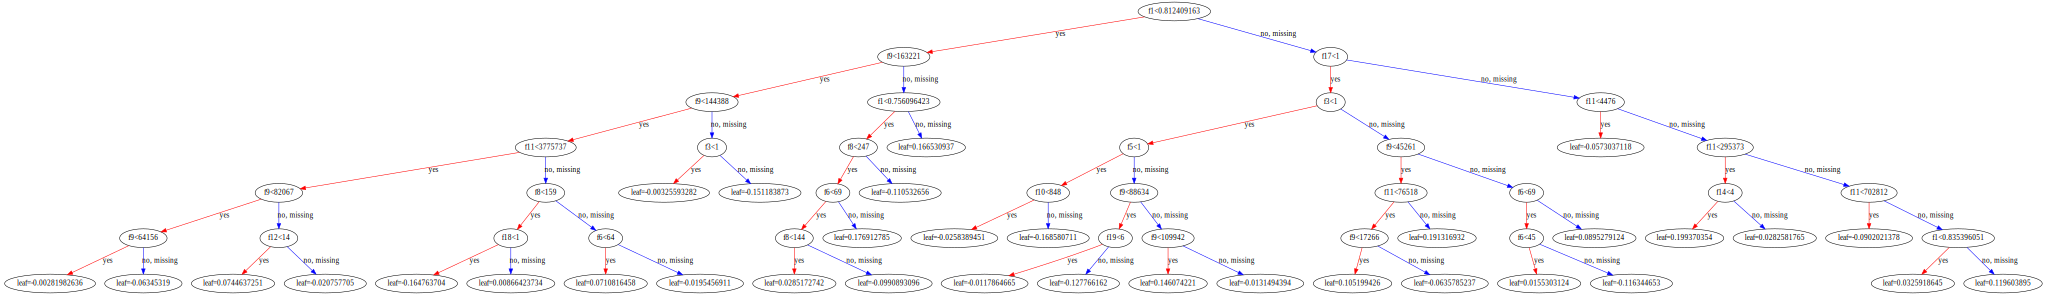

In [86]:
xgb.to_graphviz(xgb_model, num_trees=xgb_model.best_iteration)

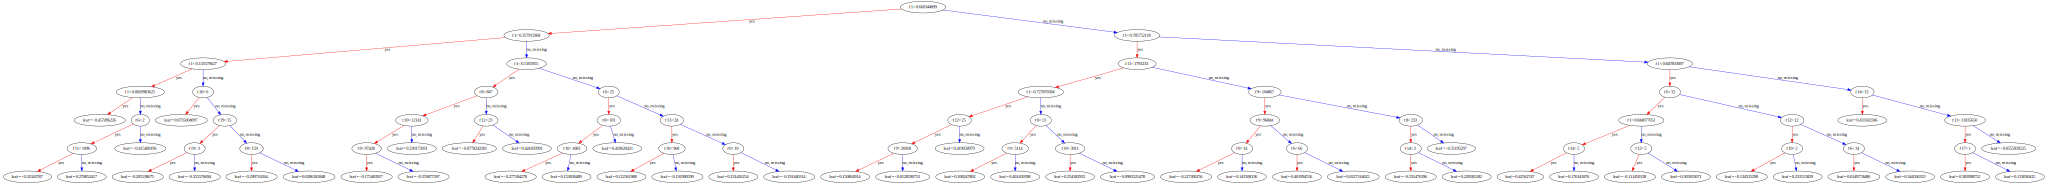

In [85]:
xgb.to_graphviz(xgb_model, num_trees=1)

## XAI

### SHAP

In [41]:
# !pip install shap

In [42]:
import shap

/Users/Shared/conda/miniconda3/envs/stats/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [201]:
# Random Forest model 
# 1 6 8 11 19
X = events[numerical_columns + categorical_columns]
# X = X.iloc[:,[1,6,8,11,19]]
# X = one_hot_encoder.fit_transform(X)
# X = X[[1,6,8,11,19]]
# X = events[numerical_columns] 
y = np.array(events[label].astype('float')).ravel()
model = RandomForestClassifier(random_state=42)
model.fit(X, y)
y_pred = model.predict(X)

# Create a tree explainer
explainer = shap.TreeExplainer(
    model, 
    feature_names=numerical_columns+categorical_columns,
)

# xgb_explainer
# Shap values with tree explainer
# shap_values = xgb_explainer.shap_values(X, y_pred)
shap_values = explainer(X)

In [110]:
# XGBoost model 
model = xgb.XGBRegressor(
    objective="binary:logistic",
    tree_method="hist", 
    enable_categorical=True,
    eval_metric='auc',
    # **search.cv_results_['params'][1],
)

model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

In [180]:
# Create a tree explainer
xgb_explainer = shap.TreeExplainer(
    model, 
    # feature_names=numerical_columns+categorical_columns,
)

# xgb_explainer
# Shap values with tree explainer
# shap_values = xgb_explainer.shap_values(X, y_pred)
shap_values = xgb_explainer(X)

TreeExplainer is a special class of SHAP, optimized to work with any tree-based model in Sklearn, XGBoost, LightGBM, CatBoost, and so on. You can use KernelExplainer for any other type of model, though it is slower than tree explainers.

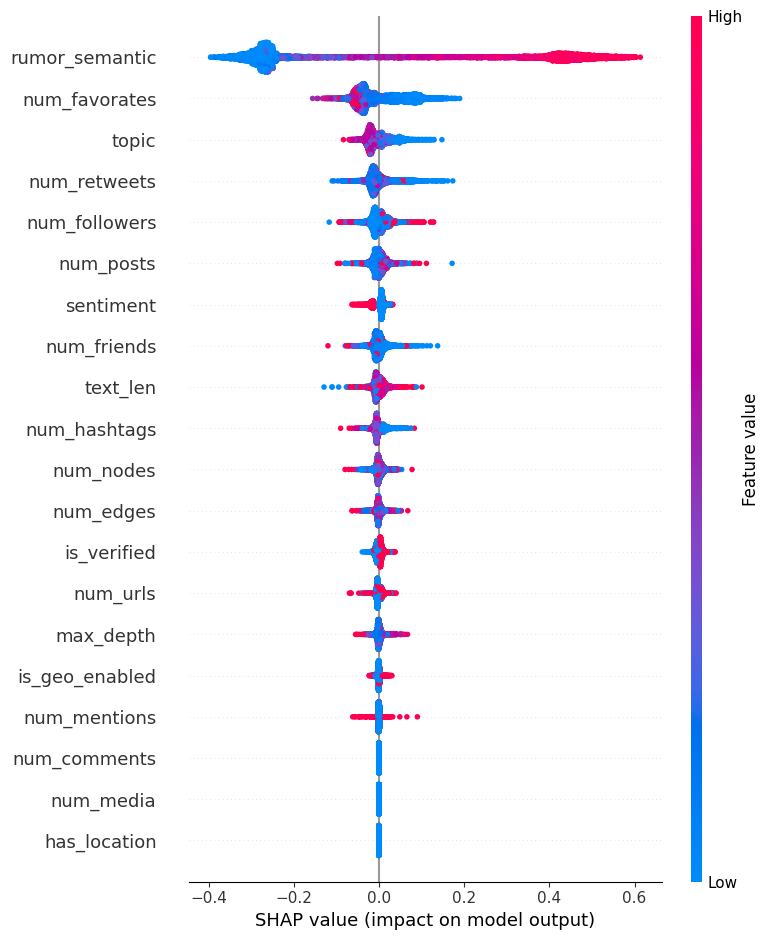

In [202]:
# shap.summary_plot(shap_values[:,:,0])
# 23, 28, 30, 33, 0
shap.summary_plot(shap_values[:,:,1])
# shap.plots.beeswarm(shap_values[:,])
# shap_values.shape

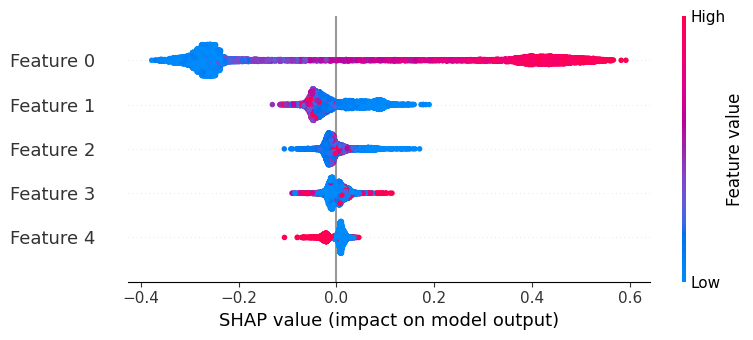

In [193]:
shap.summary_plot(shap_values[:,[23, 28, 30, 33, 0],1])


In [157]:
shap.plots.beeswarm(shap_values.abs)

AttributeError: 'list' object has no attribute 'abs'

In [151]:
X = events[numerical_columns]
# Random Forest model 
model = RandomForestClassifier(random_state=42)
model.fit(X, y)
y_pred = model.predict(X)

In [152]:
X100 = shap.utils.sample(X, 100) 
explainer = shap.Explainer(model.predict, X100)
shap_values = explainer(X)
shap.plots.beeswarm(shap_values)

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [147]:
# shap.plots.beeswarm(shap_values, X)
shap.plots.beeswarm(shap_values)

ValueError: the beeswarm plot requires Explanation object as the `shap_values` argument

In [ ]:
# Shap values with XGBoost core moedl
booster_xgb = model.get_booster()

shap_values_xgb = booster_xgb.predict(xgb.DMatrix(X_train, y_train), 
                                      pred_contribs=True)

In [ ]:
shap_values_xgb = shap_values_xgb[:, :-1]

pd.DataFrame(shap_values_xgb, columns=X_train.columns.tolist()).head()

In [ ]:
shap.summary_plot(
    shap_values_xgb, X_train, 
    feature_names=X_train.columns, plot_type="bar"
)

In [ ]:
shap.summary_plot(shap_values_xgb, X_train, feature_names=X_train.columns)

#### Exploring each feature with dependence plots

In [ ]:
shap.dependence_plot("carat", shap_values_xgb, X_train, interaction_index=None)

In [ ]:
shap.dependence_plot("carat", shap_values_xgb, 
                      X_train, interaction_index="auto");

In [ ]:
shap.dependence_plot("color", shap_values_xgb, X_train, 
                    feature_names=X_train.columns);

### Decision Tree

In [76]:
selected_features = [
    'rumor_semantic',
    'num_favorates',
    'num_retweets',
    'num_followers',
    'topic',
]

In [77]:
X_selected = events[selected_features]

In [207]:
# import DecisionTreeClassifier from sklearn
from sklearn.tree import DecisionTreeClassifier
# define a Classifier model using DecisionTreeClassifier
model = DecisionTreeClassifier(random_state=42, max_depth=4)
# fit the model with the training data
model.fit(X_selected, y)
# predict the target on the train dataset
# y_pred = model.predict(X_selected)

DecisionTreeClassifier(max_depth=4, random_state=42)

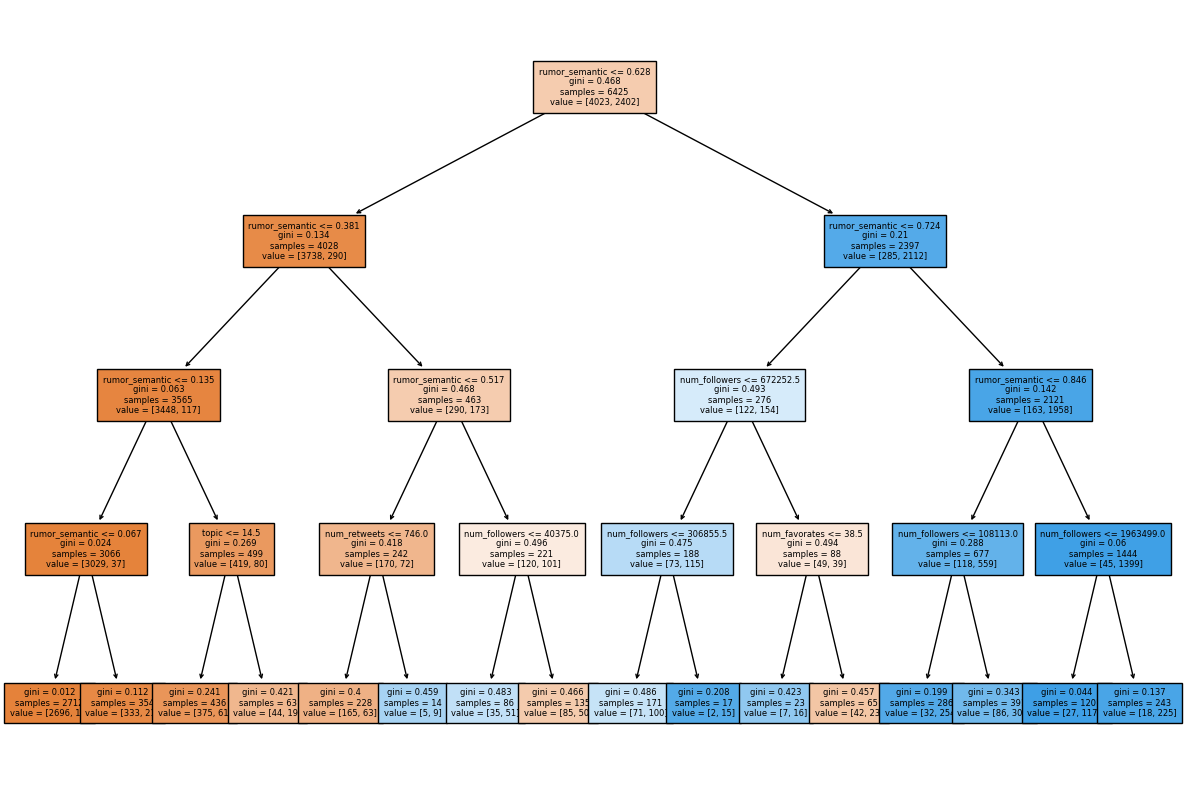

In [209]:
# visualize the model
# import pyplot as plt
import matplotlib.pyplot as plt
from sklearn import tree
plt.figure(figsize=(15,10))
tree.plot_tree(model, feature_names=X_selected.columns, filled=True, fontsize=6)
plt.show()
